# Assignment 3

Previously in 2_fullyconnected.ipynb, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in 1_notmnist.ipynb.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:

data as a flat matrix,
labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Problem 1
Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.

In [5]:
#logistic regression with SGD

batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  l2_regularization = tf.nn.l2_loss(weights)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * l2_regularization
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.002}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 23.424816
Minibatch accuracy: 7.8%
Validation accuracy: 8.1%
Minibatch loss at step 500: 2.520936
Minibatch accuracy: 80.5%
Validation accuracy: 75.9%
Minibatch loss at step 1000: 1.334135
Minibatch accuracy: 81.2%
Validation accuracy: 80.0%
Minibatch loss at step 1500: 0.682057
Minibatch accuracy: 84.4%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 0.637590
Minibatch accuracy: 86.7%
Validation accuracy: 81.6%
Minibatch loss at step 2500: 0.729655
Minibatch accuracy: 80.5%
Validation accuracy: 81.7%
Minibatch loss at step 3000: 0.713764
Minibatch accuracy: 83.6%
Validation accuracy: 82.0%
Test accuracy: 89.0%


testing for different beta how the test accuracy changes

In [7]:
num_steps = 3001
# 100 tests
beta_range = np.arange(0.0001,0.1,0.01)
print(np.shape(beta_range))
test_accuracy = []

for b in beta_range:
  print(b)
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : b}
      _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    test_accuracy.append(accuracy(test_prediction.eval(), test_labels))



(10,)
0.0001
0.0101
0.0201
0.0301
0.0401
0.0501
0.0601
0.0701
0.0801
0.0901


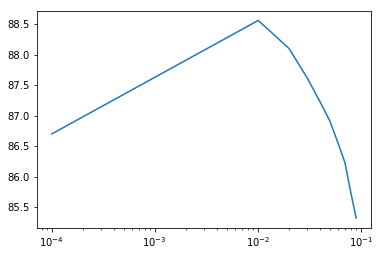

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogx(beta_range, test_accuracy)
plt.show()

In [9]:
# NN model 1-layer

batch_size = 128
layer1_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
#input data    
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    
#variables
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size,layer1_nodes]))
    B1 = tf.Variable(tf.zeros([layer1_nodes]))
    W2 = tf.Variable(tf.truncated_normal([layer1_nodes,num_labels]))
    B2 = tf.Variable(tf.zeros([num_labels]))   
    
#training computation
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + B1)
    logits = tf.matmul(layer1,W2) + B2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))
    
#optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
# Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + B1)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + B1)
    
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_validation,W2) + B2)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test,W2) + B2)
 


In [10]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.002}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 918.565918
Minibatch accuracy: 11.7%
Validation accuracy: 24.9%
Minibatch loss at step 500: 233.355362
Minibatch accuracy: 81.2%
Validation accuracy: 79.4%
Minibatch loss at step 1000: 83.446854
Minibatch accuracy: 80.5%
Validation accuracy: 83.3%
Minibatch loss at step 1500: 30.655260
Minibatch accuracy: 89.1%
Validation accuracy: 85.5%
Minibatch loss at step 2000: 11.508867
Minibatch accuracy: 90.6%
Validation accuracy: 86.4%
Minibatch loss at step 2500: 4.599708
Minibatch accuracy: 89.1%
Validation accuracy: 86.4%
Minibatch loss at step 3000: 2.123323
Minibatch accuracy: 85.9%
Validation accuracy: 86.6%
Test accuracy: 93.1%


In [44]:
num_steps = 3001
# 10 tests
beta_range = np.arange(0.000001,0.0001,0.00001)
test_accuracy = []
print(np.shape(beta_range))

for b in beta_range:
  print(b)
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : b}
      _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    test_accuracy.append(accuracy(test_prediction.eval(), test_labels))


(10,)
1e-06
1.1e-05
2.1e-05
3.1e-05
4.1e-05
5.1e-05
6.1e-05
7.1e-05
8.1e-05
9.1e-05


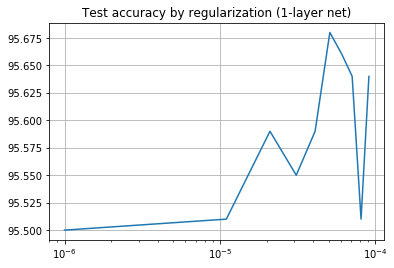

In [45]:
plt.semilogx(beta_range, test_accuracy)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

# Problem 2
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

In [13]:
# NN model 1-layer

batch_size = 128
layer1_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
#input data    
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    
#variables
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size,layer1_nodes]))
    B1 = tf.Variable(tf.zeros([layer1_nodes]))
    W2 = tf.Variable(tf.truncated_normal([layer1_nodes,num_labels]))
    B2 = tf.Variable(tf.zeros([num_labels]))   
    
#training computation
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + B1)
    logits = tf.matmul(layer1,W2) + B2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))
    
#optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
# Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + B1)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + B1)
    
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_validation,W2) + B2)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test,W2) + B2)
 

In [46]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #restrict step to 0, 1, 2, 3 or 4 (5 batches)
    offset = ((step % 5) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.0001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.599017
Minibatch accuracy: 9.4%
Validation accuracy: 34.2%
Minibatch loss at step 500: 0.157209
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Minibatch loss at step 1000: 0.149276
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Minibatch loss at step 1500: 0.144615
Minibatch accuracy: 100.0%
Validation accuracy: 79.6%
Minibatch loss at step 2000: 0.140153
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Minibatch loss at step 2500: 0.137339
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Minibatch loss at step 3000: 0.134589
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Test accuracy: 87.1%


Training accuracy goes to 100% becase fo overfitting but in the end the test accuracy is lower than previous implementations

# Problem 3
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

In [15]:
# NN model 1-layer

batch_size = 128
layer1_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
#input data    
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    
#variables
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size,layer1_nodes]))
    B1 = tf.Variable(tf.zeros([layer1_nodes]))
    W2 = tf.Variable(tf.truncated_normal([layer1_nodes,num_labels]))
    B2 = tf.Variable(tf.zeros([num_labels]))   
    
#training computation
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + B1)
    droput_layer1 = tf.nn.dropout(layer1,0.5)
    logits = tf.matmul(droput_layer1,W2) + B2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))
    
#optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
# Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + B1)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + B1)
    
    valid_prediction = tf.nn.softmax(tf.matmul(layer1_validation,W2) + B2)
    test_prediction = tf.nn.softmax(tf.matmul(layer1_test,W2) + B2)

In [16]:
#NN without overfitting
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.002}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1147.451172
Minibatch accuracy: 11.7%
Validation accuracy: 20.4%
Minibatch loss at step 500: 239.930023
Minibatch accuracy: 79.7%
Validation accuracy: 79.1%
Minibatch loss at step 1000: 84.777237
Minibatch accuracy: 74.2%
Validation accuracy: 82.6%
Minibatch loss at step 1500: 30.817894
Minibatch accuracy: 86.7%
Validation accuracy: 84.3%
Minibatch loss at step 2000: 11.606908
Minibatch accuracy: 89.8%
Validation accuracy: 85.3%
Minibatch loss at step 2500: 4.696424
Minibatch accuracy: 82.8%
Validation accuracy: 85.0%
Minibatch loss at step 3000: 2.256359
Minibatch accuracy: 82.8%
Validation accuracy: 84.9%
Test accuracy: 92.0%


In [17]:
#NN with overfitting
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    offset = ((step%5) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.002}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1160.493042
Minibatch accuracy: 8.6%
Validation accuracy: 23.9%
Minibatch loss at step 500: 232.511566
Minibatch accuracy: 100.0%
Validation accuracy: 78.8%
Minibatch loss at step 1000: 85.559181
Minibatch accuracy: 99.2%
Validation accuracy: 79.3%
Minibatch loss at step 1500: 31.466333
Minibatch accuracy: 100.0%
Validation accuracy: 79.1%
Minibatch loss at step 2000: 11.581602
Minibatch accuracy: 100.0%
Validation accuracy: 79.6%
Minibatch loss at step 2500: 4.309505
Minibatch accuracy: 100.0%
Validation accuracy: 80.0%
Minibatch loss at step 3000: 1.665819
Minibatch accuracy: 100.0%
Validation accuracy: 80.0%
Test accuracy: 87.1%


The NN with overfitting reached 100% training at a later time

# Problem 4
Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

global_step = tf.Variable(0)  # count the number of steps taken.

learning_rate = tf.train.exponential_decay(0.5, global_step, ...)

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


In [57]:
# NN model 1-layer

batch_size = 128
layer1_nodes = 1024
layer2_nodes = 1024
layer3_nodes = 1024


graph = tf.Graph()
with graph.as_default():
    
#input data    
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    
    
#variables
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size,layer1_nodes], stddev=np.sqrt(3.0 / (image_size * image_size))))
    B1 = tf.Variable(tf.zeros([layer1_nodes]))
    W2 = tf.Variable(tf.truncated_normal([layer1_nodes,layer2_nodes], stddev=np.sqrt(3.0 / layer1_nodes)))
    B2 = tf.Variable(tf.zeros([layer2_nodes]))
    W3 = tf.Variable(tf.truncated_normal([layer2_nodes,layer3_nodes], stddev=np.sqrt(3.0 / layer2_nodes)))
    B3 = tf.Variable(tf.zeros([layer3_nodes]))
    W4 = tf.Variable(tf.truncated_normal([layer3_nodes,num_labels], stddev=np.sqrt(3.0 / layer3_nodes)))
    B4 = tf.Variable(tf.zeros([num_labels]))   
    
    
    
#training computation
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + B1)
    droput_layer1 = tf.nn.dropout(layer1,0.5)
    layer2 = tf.nn.relu(tf.matmul(droput_layer1,W2) + B2)
    droput_layer2 = tf.nn.dropout(layer2,0.5)
    layer3 = tf.nn.relu(tf.matmul(droput_layer2,W3) + B3)
    droput_layer3 = tf.nn.dropout(layer3,0.5)
    logits = tf.matmul(droput_layer3,W4) + B4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4))
    
#optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 7000, 0.5,True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
# Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + B1)
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + B1)
    
    layer2_validation = tf.nn.relu(tf.matmul(layer1_validation, W2) + B2)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test, W2) + B2)
    
    layer3_validation = tf.nn.relu(tf.matmul(layer2_validation, W3) + B3)
    layer3_test = tf.nn.relu(tf.matmul(layer2_test, W3) + B3)
    
    valid_prediction = tf.nn.softmax(tf.matmul(layer3_validation,W4) + B4)
    test_prediction = tf.nn.softmax(tf.matmul(layer3_test,W4) + B4)

In [59]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.0001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.920886
Minibatch accuracy: 8.6%
Validation accuracy: 10.0%
Minibatch loss at step 1000: 0.948266
Minibatch accuracy: 82.8%
Validation accuracy: 83.6%
Minibatch loss at step 2000: 0.850311
Minibatch accuracy: 85.9%
Validation accuracy: 85.7%
Minibatch loss at step 3000: 0.915725
Minibatch accuracy: 83.6%
Validation accuracy: 86.0%
Minibatch loss at step 4000: 0.708130
Minibatch accuracy: 89.1%
Validation accuracy: 87.2%
Minibatch loss at step 5000: 0.762373
Minibatch accuracy: 87.5%
Validation accuracy: 87.3%
Minibatch loss at step 6000: 0.875146
Minibatch accuracy: 84.4%
Validation accuracy: 87.6%
Minibatch loss at step 7000: 0.770745
Minibatch accuracy: 85.9%
Validation accuracy: 88.5%
Minibatch loss at step 8000: 0.906084
Minibatch accuracy: 79.7%
Validation accuracy: 88.7%
Minibatch loss at step 9000: 0.759958
Minibatch accuracy: 86.7%
Validation accuracy: 88.9%
Minibatch loss at step 10000: 0.627237
Minibatch accuracy: 85.9%
Validation accura

# Results
reached 96.4% on testing
    no dropout
    2 hidden layers
    1000 decay steps
    0.5 decay rate
    10 000 epochs